# ★퀘스트★

### 오늘 배운 모델들을 활용하여 (DT, KNN, XGBOOST / RF는 제외!!) 이보다 더 정교한 모델을 만들어보아요.
### 목표는 정확도 > 63%

(+추가)
같은 모델이더라도, 하이퍼 파라미터를 바꿔가며 코드를 실행해보면 결과가 달라집니다. 예를 들어 RF에서 나무의 개수!

또는 모델에 들어갈 x 변수를 더 늘리거나 줄여도 성능이 달라집니다.

time 모듈을 활용하여 각 모델별로 걸리는 시간도 측정해보세요.

모르는 게 있으면 질문해주세요!

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("AB_NYC_2019.csv")

In [3]:
df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


In [4]:
# 브루클린, 맨하튼 숙소만
our_set = df[df['neighbourhood_group'].isin(['Brooklyn', 'Manhattan'])]
df.shape, our_set.shape,

((48895, 16), (41765, 16))

Text(0, 0.5, 'Ratio')

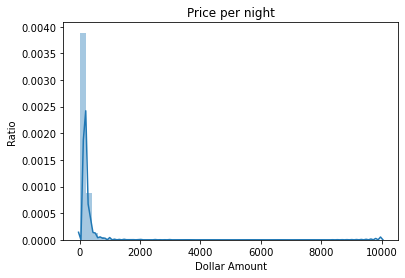

In [5]:
#가격대 분포

sns.distplot(our_set['price'])
plt.title("Price per night")
plt.xlabel('Dollar Amount')
plt.ylabel('Ratio')

Text(0, 0.5, 'Ratio')

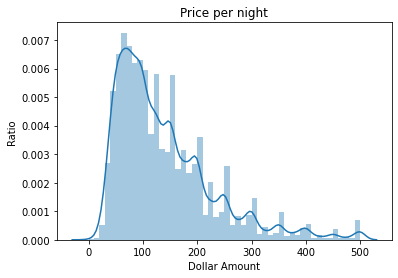

In [6]:
#이상치 제거 후 분포
sns.distplot(our_set[our_set['price']<=500]['price'])
plt.title("Price per night")
plt.xlabel('Dollar Amount')
plt.ylabel('Ratio')

In [7]:
onehot = pd.get_dummies(our_set['room_type'])
onehot

,Entire home/apt,Private room,Shared room
0,0,1,0
1,1,0,0
2,0,1,0
3,1,0,0
4,1,0,0
...,...,...,...
48890,0,1,0
48891,0,1,0
48892,1,0,0
48893,0,0,1


In [8]:
core_cols = our_set[['neighbourhood_group', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']]
combined = core_cols.merge(onehot, left_index=True, right_index=True, how='left').reset_index()

In [9]:
final = combined.drop(columns=['index']).dropna()
final = final.replace('Brooklyn', 0).replace('Manhattan', 1)

In [10]:
final.head()

,neighbourhood_group,price,minimum_nights,number_of_reviews,reviews_per_month,Entire home/apt,Private room,Shared room
0,0,149,1,9,0.21,0,1,0
1,1,225,1,45,0.38,1,0,0
3,0,89,1,270,4.64,1,0,0
4,1,80,10,9,0.10,1,0,0
5,1,200,3,74,0.59,1,0,0


## Decision Tree

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
import time

In [14]:
X = final[['price','minimum_nights','number_of_reviews','reviews_per_month','Entire home/apt','Private room','Shared room']]
y = final['neighbourhood_group']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 10)

In [16]:
#max depth 3부터 9까지 설정
for i in range(3, 10):
    clf = tree.DecisionTreeClassifier(max_depth = i, random_state = 10)
    
    t0 = time.time()
    clf.fit(X_train,y_train)
    elapsed = time.time()-t0
    
    
    print('max depth {}'.format(i))
    print('train set score {:3f}'.format(clf.score(X_train,y_train)))
    print('test set score {:3f}'.format(clf.score(X_test,y_test)))
    print("걸린시간은 {:.3f}초입니다.".format(elapsed))
    print('-'*60)

max depth 3
train set score 0.639346
test set score 0.649486
걸린시간은 0.031초입니다.
------------------------------------------------------------
max depth 4
train set score 0.655028
test set score 0.660973
걸린시간은 0.037초입니다.
------------------------------------------------------------
max depth 5
train set score 0.657786
test set score 0.663392
걸린시간은 0.034초입니다.
------------------------------------------------------------
max depth 6
train set score 0.665193
test set score 0.668682
걸린시간은 0.039초입니다.
------------------------------------------------------------
max depth 7
train set score 0.669161
test set score 0.667322
걸린시간은 0.043초입니다.
------------------------------------------------------------
max depth 8
train set score 0.675963
test set score 0.664450
걸린시간은 0.056초입니다.
------------------------------------------------------------
max depth 9
train set score 0.684390
test set score 0.660067
걸린시간은 0.057초입니다.
------------------------------------------------------------


> max depth가 6일때 test set score이 0.668682로 가장 높은 성능을 보여준다.

## KNN

In [18]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors = 3, n_jobs = -1, p=2, leaf_size =30)

In [19]:
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.7824131806673469
0.5946191051995163


In [20]:
#표준화 처리
from sklearn.preprocessing import StandardScaler

X_train_scaled = StandardScaler().fit_transform(X_train[['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']])
X_test_scaled = StandardScaler().fit_transform(X_test[['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']])

In [24]:
score = np.zeros(len(np.arange(1,101)))
t0 = time.time()

for i, K, in enumerate(range(1,101)):
    model = model = KNeighborsClassifier(n_neighbors = K, n_jobs = -1, p=2, leaf_size =30)
    model.fit(X_train_scaled, y_train.values.ravel())
    model.score(X_train_scaled, y_train)
    score[i] = model.score(X_test_scaled, y_test)
    
print("소요시간: {:.3f} sec".format(time.time()-t0))

#시간이 아주 많이 걸리네요...

소요시간: 240.489 sec


In [25]:
score

array([0.57240024, 0.55501814, 0.58116687, 0.57179565, 0.59431681,
       0.58131802, 0.60187424, 0.59386336, 0.60973398, 0.60368803,
       0.61094317, 0.60126965, 0.61185006, 0.60716445, 0.61426844,
       0.60958283, 0.61381499, 0.60852479, 0.61426844, 0.61154776,
       0.61804716, 0.61819831, 0.61804716, 0.61457074, 0.61865175,
       0.6185006 , 0.62409311, 0.61986094, 0.62258162, 0.6191052 ,
       0.62379081, 0.61819831, 0.6253023 , 0.62212817, 0.62394196,
       0.62212817, 0.62076784, 0.62333736, 0.62484885, 0.62091898,
       0.62605804, 0.61986094, 0.62318622, 0.6188029 , 0.62107013,
       0.61668682, 0.62303507, 0.62167473, 0.62333736, 0.62091898,
       0.62243047, 0.62031439, 0.61986094, 0.6191052 , 0.62016324,
       0.61834946, 0.62031439, 0.61925635, 0.62137243, 0.62046554,
       0.62152358, 0.61925635, 0.62167473, 0.61955865, 0.62031439,
       0.6185006 , 0.62227932, 0.62061669, 0.62091898, 0.62016324,
       0.61970979, 0.62016324, 0.62061669, 0.61895405, 0.61955

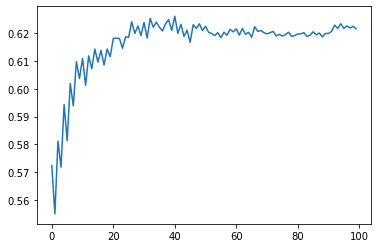

In [26]:
%matplotlib inline
plt.plot(score)

#x축이 k의 값, y축이 정확도

In [32]:
score.argmax()

40

In [64]:
#K=41 일때
t0 = time.time()
model = KNeighborsClassifier(n_neighbors = 41, n_jobs = -1, p=2, leaf_size =30)
model.fit(X_train_scaled, y_train.values.ravel())
model.score(X_train_scaled, y_train)

print(model.score(X_train_scaled, y_train))
print(model.score(X_test_scaled, y_test))
print("소요시간: {:.3f} sec".format(time.time()-t0))

0.6435022484223255
0.6260580411124547
소요시간: 3.315 sec


In [65]:
#표준화 처리 전 모델
t0 = time.time()
model = KNeighborsClassifier(n_neighbors = 41, n_jobs = -1, p=2, leaf_size =30)
model.fit(X_train, y_train.values.ravel())
model.score(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))
print("소요시간: {:.3f} sec".format(time.time()-t0))

0.6500774666515512
0.6372430471584039
소요시간: 2.915 sec


> K가 41일때 가장 좋은 성능을 보여주지만, test set score이 0.626으로 설명력이 높은 편은 아니다.   
표준화를 하기 전의 데이터에서 설명력이 더 높게 나타나는 것을 알 수 있다.   
소요시간 또한 DT에 비해 오래 걸린다.

## XGBOOST

In [44]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score 

In [66]:
t0 = time.time()
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:3f}".format(accuracy))
print("소요시간: {:.3f} sec".format(time.time()-t0))

Accuracy: 0.662787
소요시간: 0.646 sec


In [67]:
model = XGBClassifier(learning_rate= 0.1, max_depth= 5, n_estimators= 100)
t0 = time.time()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:3f}".format(accuracy))
print("소요시간: {:.3f} sec".format(time.time()-t0))

Accuracy: 0.671856
소요시간: 0.575 sec


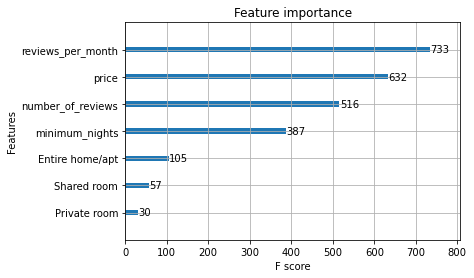

In [63]:
from xgboost import plot_importance
plot_importance(model)

> XGBoost의 파라미터를 조정하며 값을 구해본 결과, learning_rate= 0.1, max_depth= 5, n_estimators= 100일 때 정확도가 0.671856으로 가장 높았다. DT와 KNN에서 구한 값들에 비해서도 높은 성능을 보여준다.